# Convert this notebook to be comparison of ClimateNA vs GRIDMET

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from refit_fvs.hargreaves import (
    et_rad,
    hargreaves,
    inv_rel_dist_earth_sun,
    sol_dec,
    sunset_hour_angle,
)
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
PLOTS = "../../data/interim/plot_info_for_climatena.csv"
plots = (
    pd.read_csv(PLOTS).rename({"ID1": "PLOT_ID"}, axis=1).drop("ID2", axis=1)
).set_index("PLOT_ID")
plots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     12156 non-null  float64
 1   lon     12156 non-null  float64
 2   el      12156 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 379.9 KB


In [6]:
CLIMNA = "../../data/interim/climatena_1990-2020_monthly_long.csv"
climna = pd.read_csv(
    CLIMNA,
    usecols=["PLOT_ID", "PERIOD", "PPT", "EREF", "TMIN", "TMAX"],
    dtype={"PERIOD": "period[M]"},
).set_index(["PLOT_ID", "PERIOD"])
climna.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4522032 entries, (60101550679, Period('1990-01', 'M')) to (530907572668, Period('2020-12', 'M'))
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   TMAX    float64
 1   TMIN    float64
 2   PPT     int64  
 3   EREF    int64  
dtypes: float64(2), int64(2)
memory usage: 155.6 MB


In [7]:
climna.loc[60101550679, "2010-01"]

TMAX      9.8
TMIN      3.2
PPT     411.0
EREF     23.0
Name: (60101550679, 2010-01), dtype: float64

In [8]:
monthly_gridmet = gridmet.groupby(
    by=["PLOT_ID", gridmet.DATE.dt.year, gridmet.DATE.dt.month]
).agg({"TMIN": "mean", "TMAX": "mean", "PPT": "sum", "EREF_HARGREAVES": "sum"})
monthly_gridmet["PERIOD"] = pd.PeriodIndex(
    (
        monthly_gridmet.index.get_level_values(1).astype(str).values
        + "-"
        + monthly_gridmet.index.get_level_values(2).astype(str).values
    ),
    freq="M",
)
monthly_gridmet = monthly_gridmet.reset_index(level=[1, 2], drop=True).set_index(
    "PERIOD", append=True
)
avg_temp = (monthly_gridmet.TMIN + monthly_gridmet.TMAX) / 2 - 273.15
monthly_gridmet.loc[avg_temp < 0, "EREF_HARGREAVES"] = 0
monthly_gridmet.head()

TMIN        TMAX         PPT  EREF_HARGREAVES
PLOT_ID     PERIOD                                                      
60101550679 2010-01  274.993394  283.110818  337.364031        27.691722
            2010-02  274.562718  283.800302  304.492383        36.878516
            2010-03  273.115790  284.653349  420.644989        62.316458
            2010-04  273.719991  285.792421  436.341300        82.342718
            2010-05  276.071287  289.047886  193.021104       112.362823

In [9]:
monthly_clim = climna.merge(
    monthly_gridmet, how="inner", left_index=True, right_index=True
)
monthly_clim.head()

TMAX_x  TMIN_x  PPT_x  EREF      TMIN_y      TMAX_y  \
PLOT_ID     PERIOD                                                         
60101550679 2010-01     9.8     3.2    411    23  274.993394  283.110818   
            2010-02    10.3     2.2    318    32  274.562718  283.800302   
            2010-03    11.3     0.7    396    55  273.115790  284.653349   
            2010-04    11.8     1.0    386    70  273.719991  285.792421   
            2010-05    15.8     3.3    182   102  276.071287  289.047886   

                          PPT_y  EREF_HARGREAVES  
PLOT_ID     PERIOD                                
60101550679 2010-01  337.364031        27.691722  
            2010-02  304.492383        36.878516  
            2010-03  420.644989        62.316458  
            2010-04  436.341300        82.342718  
            2010-05  193.021104       112.362823

In [10]:
(
    r2_score(monthly_clim.PPT_x, monthly_clim.PPT_y),
    r2_score(monthly_clim.EREF, monthly_clim.EREF_HARGREAVES),
    r2_score(monthly_clim.TMIN_x, monthly_clim.TMIN_y - 273.15),
    r2_score(monthly_clim.TMAX_x, monthly_clim.TMAX_y - 273.15),
)

(0.9370702056268043,
 0.9444136888507978,
 0.9710645233002753,
 0.9841701921460843)

In [11]:
(
    mean_absolute_error(monthly_clim.PPT_x, monthly_clim.PPT_y),
    mean_absolute_error(monthly_clim.EREF, monthly_clim.EREF_HARGREAVES),
    mean_absolute_error(monthly_clim.TMIN_x, monthly_clim.TMIN_y - 273.15),
    mean_absolute_error(monthly_clim.TMAX_x, monthly_clim.TMAX_y - 273.15),
)

(19.377123490663156, 8.981201964854884, 0.7611225640637701, 0.8119472255916006)

In [12]:
(
    abs((monthly_clim.PPT_x - monthly_clim.PPT_y).mean()),
    abs((monthly_clim.EREF - monthly_clim.EREF_HARGREAVES).mean()),
    abs((monthly_clim.TMIN_x - (monthly_clim.TMIN_y - 273.15)).mean()),
    abs((monthly_clim.TMAX_x - (monthly_clim.TMAX_y - 273.15)).mean()),
)

(7.008701790636779,
 6.48065111793422,
 0.37206591822928387,
 0.015790296987386515)

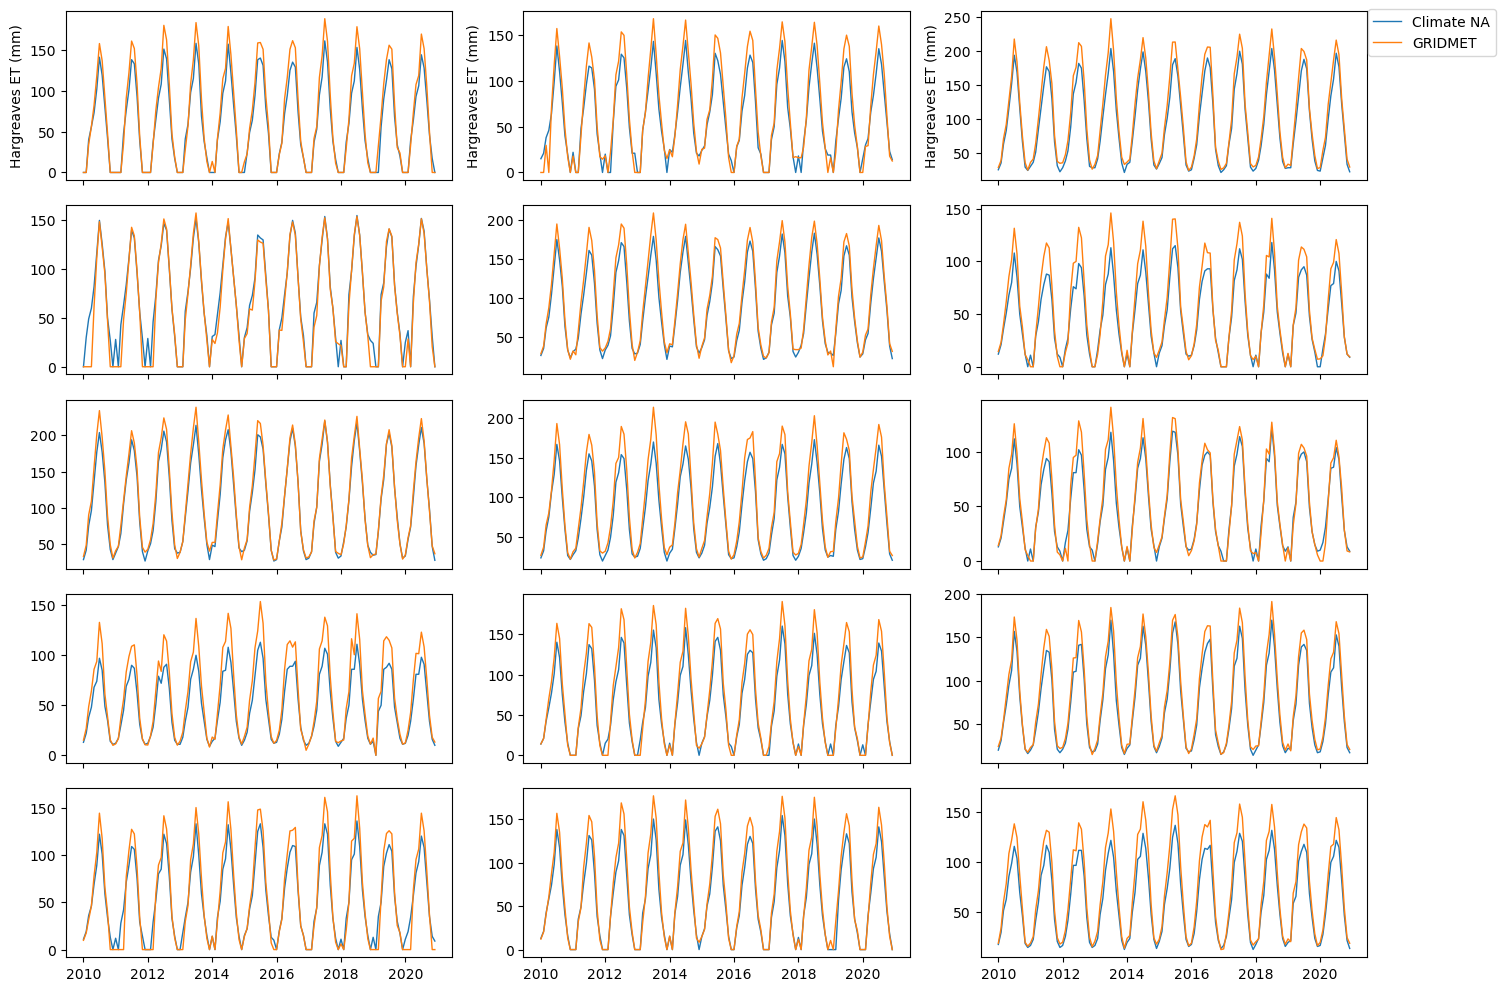

In [13]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10), sharex=True, sharey=False)
plots_to_plot = np.random.choice(np.unique(monthly_clim.index.get_level_values(0)), 15)
for i, plot in enumerate(plots_to_plot):
    to_plot = monthly_clim.loc[plot]
    dates = to_plot.index.to_timestamp()
    axs.ravel()[i].plot(dates, to_plot.EREF, lw=1, label="Climate NA")
    axs.ravel()[i].plot(dates, to_plot.EREF_HARGREAVES, lw=1, label="GRIDMET")
axs[0, -1].legend(bbox_to_anchor=(1.35, 1.05))
for ax in axs[0, :]:
    ax.set_ylabel("Hargreaves ET (mm)")
plt.tight_layout()
plt.show()

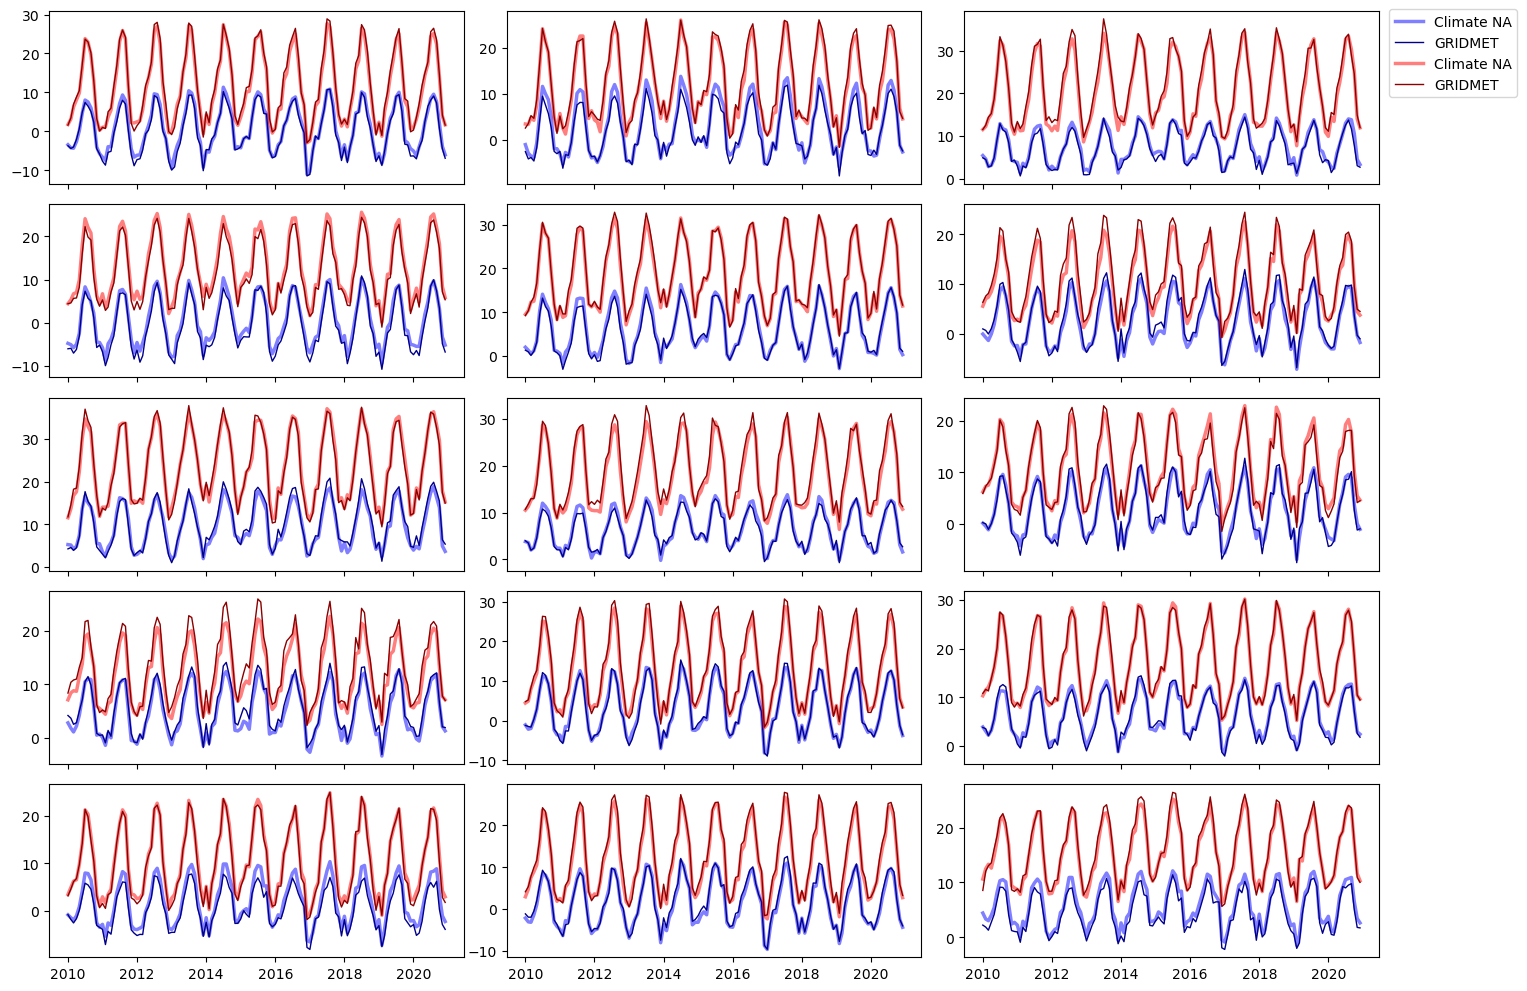

In [14]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10), sharex=True, sharey=False)
for i, plot in enumerate(plots_to_plot):
    to_plot = monthly_clim.loc[plot]
    dates = to_plot.index.to_timestamp()
    axs.ravel()[i].plot(
        dates, to_plot.TMIN_x, lw=2.5, alpha=0.5, label="Climate NA", color="blue"
    )
    axs.ravel()[i].plot(
        dates, to_plot.TMIN_y - 273.15, lw=1, label="GRIDMET", color="darkblue"
    )
    axs.ravel()[i].plot(
        dates, to_plot.TMAX_x, lw=2.5, alpha=0.5, label="Climate NA", color="red"
    )
    axs.ravel()[i].plot(
        dates, to_plot.TMAX_y - 273.15, lw=1, label="GRIDMET", color="darkred"
    )
axs[0, -1].legend(bbox_to_anchor=(1.35, 1.05))
plt.tight_layout()
plt.show()